# GTFS Feeds

API documentation can be found in: https://www.transit.land/documentation/datastore/api-endpoints

In [ ]:
%matplotlib inline

In [1]:
import json
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry
import geopandas as gpd
from functools import lru_cache

In [2]:
url = "https://transit.land/api/v1/feeds"

In [3]:
@lru_cache(maxsize=None)
def cached_requests(url, num_retries=5):
    for i in range(num_retries):
        r = requests.get(url)
        data = r.json()
        if 'meta' in data:
            return data
        else:
            print(data)
        
        time.sleep(5)

In [ ]:
feeds = []
items = cached_requests(url)
feeds.extend(items['feeds'])

while True:
    next_url = items.get('meta', {}).get('next')
    print(next_url)
    if next_url is not None:
        items = cached_requests(next_url)
        if 'feeds' in items:
            feeds.extend(items['feeds'])
    else:
        break

In [8]:
with open("data/feeds.json", "w") as f:
    json.dump(feeds, f)

# Explore Data

In [2]:
with open("data/feeds.json", 'r') as f:
    feeds = json.load(f)

In [16]:
df = pd.DataFrame(feeds)
df.head(2)

,geometry,onestop_id,created_at,updated_at,tags,created_or_updated_in_changeset_id,name,url,feed_format,spec,...,associated_feeds,languages,feed_namespace_id,license_name,license_url,license_use_without_attribution,license_create_derived_product,license_redistribute,license_attribution_text,operators_in_feed
0,"{'type': 'Polygon', 'coordinates': [[[-122.412...",f-9q9-caltrain,2016-02-06T20:03:44.650Z,2021-05-20T07:00:05.605Z,"{'demo_feed': 'true', 'gtfs_data_exchange': 'c...",14783.0,Caltrain,http://data.trilliumtransit.com/gtfs/caltrain-...,gtfs,gtfs,...,None,None,o-9q9-caltrain,None,http://www.caltrain.com/developer.html,yes,yes,unknown,None,"[{'gtfs_agency_id': '1000', 'operator_onestop_..."
1,"{'type': 'Polygon', 'coordinates': [[[-122.468...",f-9q9-bart,2016-02-06T20:03:47.644Z,2021-05-20T07:00:05.548Z,"{'demo_feed': 'true', 'gtfs_data_exchange': 'a...",7832.0,None,http://www.bart.gov/dev/schedules/google_trans...,gtfs,gtfs,...,None,None,o-9q9-bart,None,http://www.bart.gov/schedules/developers/devel...,yes,unknown,unknown,None,"[{'gtfs_agency_id': '', 'operator_onestop_id':..."


# Visualize Bounding Boxes

In [17]:
df['geometry'] = df['geometry'].apply(
    lambda g: shapely.geometry.Point() if g is None else shapely.geometry.shape(g))
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

gdf_ne = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
mask = gdf_ne['continent'] != "Antarctica"
gdf_ne = gdf_ne[mask]

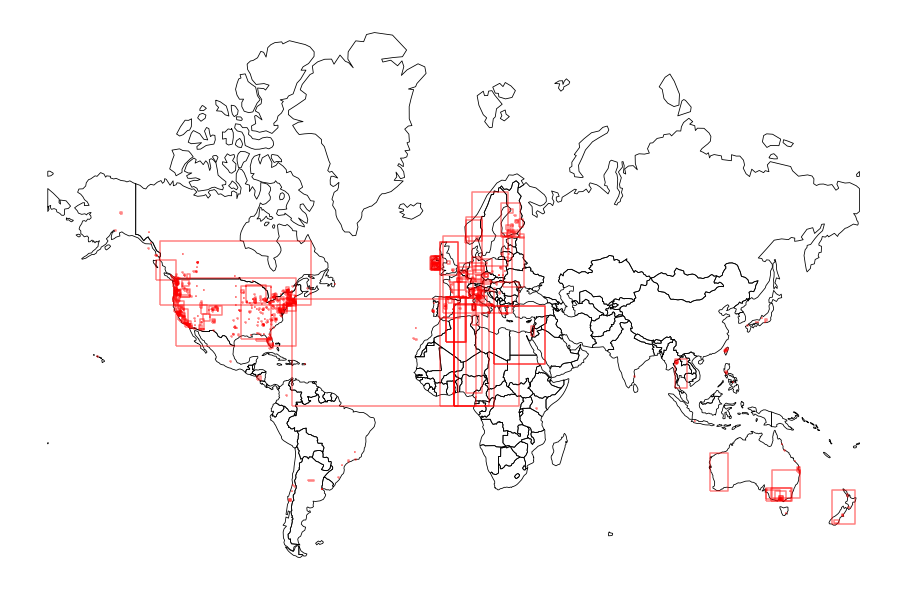

In [108]:
fig, ax = plt.subplots(figsize=(16, 12))

epsg=3857
gdf_ne.boundary.to_crs(epsg=epsg).plot(ax=ax, color='k', linewidth=0.8)
gdf.boundary.to_crs(epsg=epsg).plot(ax=ax, alpha=0.5, color='r')

ax.axis('off');

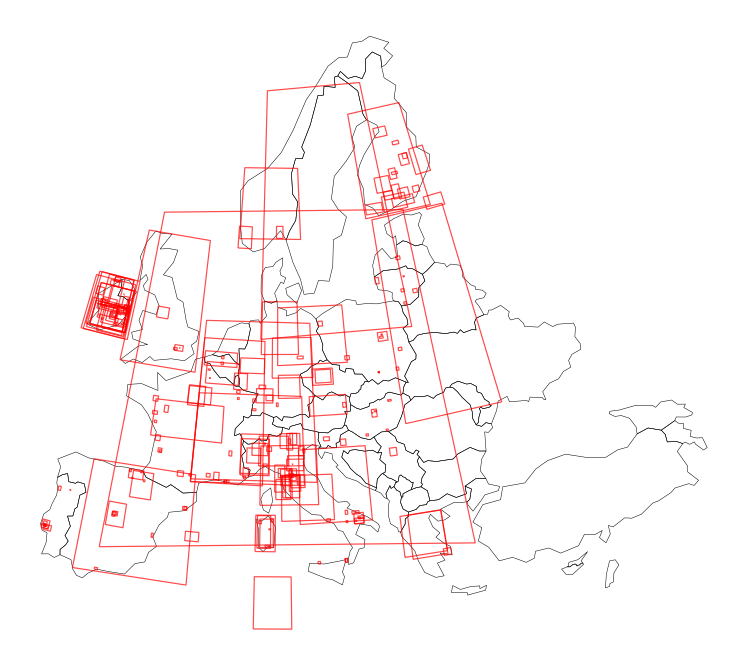

In [149]:
fig, ax = plt.subplots(figsize=(16, 12))

EXTENT = [-19.6,32.9,47.7,72.2]
bbox = shapely.geometry.box(*EXTENT)

# Filter France and Norway
mask = (gdf_ne['name'] == 'France') | (gdf_ne['name'] == 'Norway') 
gdf_ne.loc[mask, 'geometry'] = gdf_ne[mask].intersection(bbox)

mask_ne = gdf_ne.within(bbox)
mask = gdf.within(bbox)

epsg=3035
gdf_ne[mask_ne].boundary.to_crs(epsg=epsg).plot(
    ax=ax, color='k', linewidth=0.5)
gdf[mask].boundary.to_crs(epsg=epsg).plot(
    ax=ax, alpha=0.7, color='r', linewidth=1.2)

ax.axis('off');

# Number of GTFS Feeds Created/Added Over Time

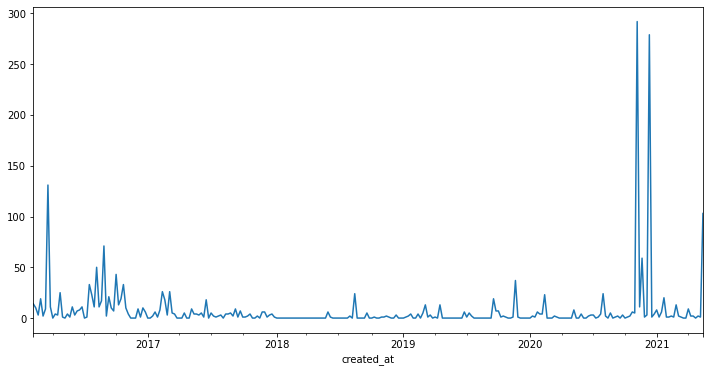

In [75]:
df['updated_at'] = pd.to_datetime(df['updated_at'])
df['created_at'] = pd.to_datetime(df['created_at'])

df.set_index('created_at') \
    .resample('W') \
    .count()['feed_versions'] \
    .plot(figsize=(12, 6));